In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

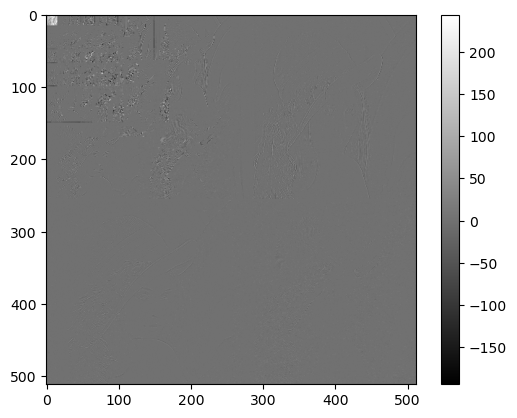

In [2]:
# load image
img = np.load('l5_decomp_quant.npy')
plt.imshow(img, cmap='gray')
plt.colorbar()

In [17]:
# create a EZW tree class
class EZWTree:
    def __init__(self, value, level, quadrant, coordinates, children, parent):
        self.value = value
        self.level = level
        self.children = children if children is not None else []
        self.quadrant = quadrant
        self.coordinates = coordinates
        self.ezwcode = None
        self.parent = parent if parent is not None else None
    
def build_tree(image, level=0, coordinates=(1,0), quadrant=None, parent=None):
    i, j = coordinates
    # Base case: if the coordinates are out of the image boundary, return None
    if i >= image.shape[0] or j >= image.shape[1]:
        return None

    # create the list of children coordinates / quadrant 2,1,3,4
    child_coordinates = [(2*i, 2*j), (2*i, 2*j+1), (2*i + 1, 2*j), (2*i + 1, 2*j + 1)]

    node = EZWTree(image[i, j], level, quadrant, coordinates, children=[], parent=parent)

    # recursively create the children
    for coord in child_coordinates:
        ci, cj = coord
        # Check if the child coordinates are within the image boundary
        if ci < image.shape[0] and cj < image.shape[1]:
            child = build_tree(image, level+1, coord, quadrant, parent=node)
            node.children.append(child)

    return node

In [18]:
# enumerate the img[0,16:0,16]
root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(img, 1, (i,j+16), 1, None)
        child_3 = build_tree(img, 1, (i+16,j), 3, None)
        child_4 = build_tree(img, 1, (i+16,j+16), 4, None)
        root_nodes[i][j] = EZWTree(img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = root_nodes[i][j] # type: ignore
        child_3.parent = root_nodes[i][j] # type: ignore
        child_4.parent = root_nodes[i][j] # type: ignore

## Set ezw code

- P non-zero
- Z isolated zero
- T zero tree root

In [19]:
def dfs_set_value(node):
    # base case: if node is None, return False
    if node is None:
        return False

    # first process the children
    children_significant = [dfs_set_value(child) for child in node.children]

    # process the current node
    if np.abs(node.value) != 0:
        node.ezwcode = 'P' #Positive or negative non-zero
        return True
    else:
        # does code have significant descendant?
        if any(children_significant):
            node.ezwcode = 'Z' #Isolated zero
            return True
        else:
            node.ezwcode = 'T' #ZTR
            return False

In [20]:
def bfs_encode_list(root):
    # use BFS to traverse the tree
    queue = root.children.copy()
    dominant_pass_result = []
    while queue:
        node = queue.pop(0)
        # check ezwcode
        # check if the node is significant
        if node.ezwcode == 'P':
            dominant_pass_result.append(node.value)
        elif node.ezwcode == 'Z':
            dominant_pass_result.append(node.value)
        elif node.ezwcode == 'T':
            dominant_pass_result.append(node.ezwcode)
            continue
        # add the children to the queue
        if node.children:
            queue.extend(node.children)
    return dominant_pass_result

In [21]:
def transverse_encode(root):
    # use DFS to traverse the tree and set the ezwcode
    dfs_set_value(root)
    # use BFS to export the dominant_pass_result
    dominant_pass_result = bfs_encode_list(root)
    return dominant_pass_result


In [22]:
def enc_dp_sp(root_nodes_list):
    dpr_list = [[None for _ in range(16)] for _ in range(16)]
    for i in range(0, 16):
        for j in range(0, 16):
            dpr_list[i][j] = transverse_encode(root_nodes_list[i][j])
            print('coor', root_nodes_list[i][j].coordinates, 'done')
    return dpr_list

In [23]:
dpr_list= enc_dp_sp(root_nodes) # accuracte case is int(np.log2(threshold_enc_dec))+1

coor (0, 0) done
coor (0, 1) done
coor (0, 2) done
coor (0, 3) done
coor (0, 4) done
coor (0, 5) done
coor (0, 6) done
coor (0, 7) done
coor (0, 8) done
coor (0, 9) done
coor (0, 10) done
coor (0, 11) done
coor (0, 12) done
coor (0, 13) done
coor (0, 14) done
coor (0, 15) done
coor (1, 0) done
coor (1, 1) done
coor (1, 2) done
coor (1, 3) done
coor (1, 4) done
coor (1, 5) done
coor (1, 6) done
coor (1, 7) done
coor (1, 8) done
coor (1, 9) done
coor (1, 10) done
coor (1, 11) done
coor (1, 12) done
coor (1, 13) done
coor (1, 14) done
coor (1, 15) done
coor (2, 0) done
coor (2, 1) done
coor (2, 2) done
coor (2, 3) done
coor (2, 4) done
coor (2, 5) done
coor (2, 6) done
coor (2, 7) done
coor (2, 8) done
coor (2, 9) done
coor (2, 10) done
coor (2, 11) done
coor (2, 12) done
coor (2, 13) done
coor (2, 14) done
coor (2, 15) done
coor (3, 0) done
coor (3, 1) done
coor (3, 2) done
coor (3, 3) done
coor (3, 4) done
coor (3, 5) done
coor (3, 6) done
coor (3, 7) done
coor (3, 8) done
coor (3, 9) d

## reconstruct image

In [25]:
# enumerate the img[0,16:0,16]
recon_img = np.zeros((512,512)).astype('float64')
recon_root_nodes = [[None for _ in range(16)] for _ in range(16)]
for i in range(0, 16):
    for j in range(0, 16):
        # in order of quadrant 1,3,4
        child_1 = build_tree(recon_img, 1, (i,j+16), 1, None)
        child_3 = build_tree(recon_img, 1, (i+16,j), 3, None)
        child_4 = build_tree(recon_img, 1, (i+16,j+16), 4, None)
        recon_root_nodes[i][j] = EZWTree(recon_img[i, j], 0, 2, (i,j), [child_1, child_3, child_4], None) # type: ignore
        child_1.parent = recon_root_nodes[i][j] # type: ignore
        child_3.parent = recon_root_nodes[i][j] # type: ignore
        child_4.parent = recon_root_nodes[i][j] # type: ignore

In [27]:
def decode_tree(root, dominant_pass):
    # print('------')
    # print('threshold:', threshold )
    # print(root.coordinates)
    # print(dominant_pass)
    # print(subdominant_pass)
    queue = root.children.copy()
    idx = 0
    
    while queue:
        node = queue.pop(0)
        ezwcode = dominant_pass[idx]
        i, j = node.coordinates
        if ezwcode != "T":
            recon_img[i, j] = ezwcode
            idx += 1
            # print(idx, node.coordinates, node.value)
        elif ezwcode == 'T': # ZTR
            idx += 1
            # print('T')
            continue
        if node.children:
            queue.extend(node.children)
    return


In [28]:
def dec_dp_sp(dpr_list):
    for i in range(0, 16):
        for j in range(0, 16):
            decode_tree(recon_root_nodes[i][j], dpr_list[i][j])

In [29]:
dec_dp_sp(dpr_list)

In [30]:
bin_img = np.zeros((512,512))
bin_img[img != 0] = 1
check_filled = np.zeros((512,512))
check_filled[recon_img != 0] = 1

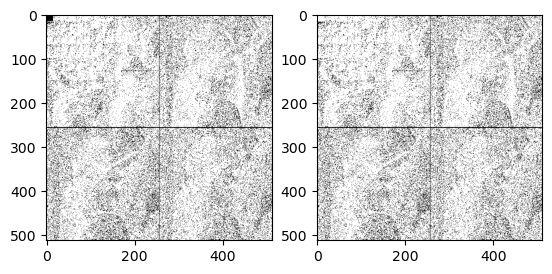

In [31]:
# plot check_filled and bin_img
plt.figure()
plt.subplot(1,2,1)
plt.imshow(check_filled, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(bin_img,  cmap='gray')

In [32]:
recon_img[0:16,0:16] = img[0:16,0:16]

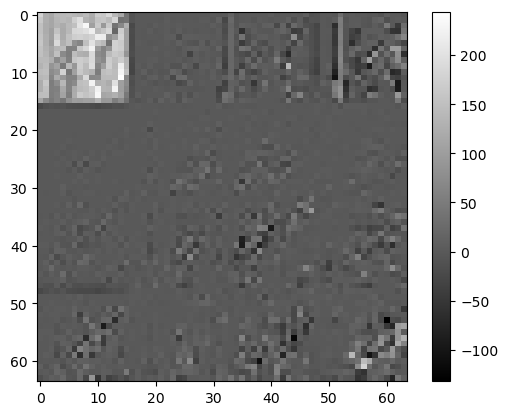

In [33]:
plt.imshow(img[0:64,0:64], cmap='gray')
plt.colorbar()

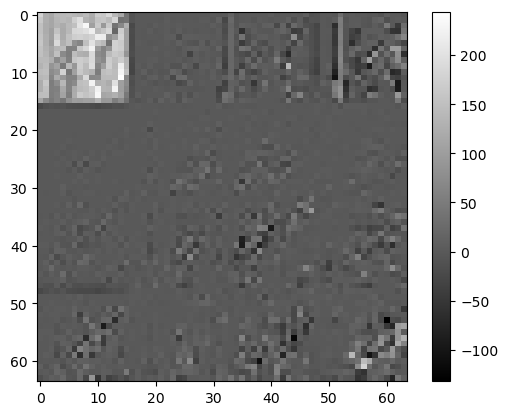

In [34]:
plt.imshow(recon_img[0:64,0:64], cmap='gray')
plt.colorbar()

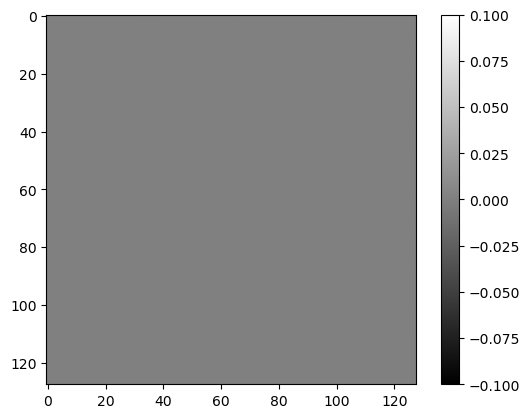

In [35]:
plt.imshow(((recon_img)-img)[0:128,0:128], cmap='gray')
# limit intensity at 10
plt.colorbar()

In [36]:
# calculate psnr between img and recon_img
def psnr(img, recon_img):
    mse = np.mean((img - recon_img)**2)
    return 10 * np.log10(255**2/mse), mse
psnr(img, recon_img)

/tmp/ipykernel_1200009/3287060163.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10(255**2/mse), mse


(inf, 0.0)

In [24]:
# save reconstructed image to npy
np.save('recon_img_ezw.npy', recon_img)

----
test threshold

In [25]:
# img_c = img.copy()
# recon_img[0:16,0:16] = 0